# Determinare la commestibilità di un fungo

**Programmazione di Applicazioni Data Intensive**  

Mauro Pellonara

## Descrizione del problema

L'obiettivo del progetto è sviluppare un modello che, basandosi su misurazioni effettuate su un fungo, possa determinarne la commestibilità.

## Librerie

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import json
from os import path
from urllib.request import urlretrieve
from sklearn.preprocessing import OrdinalEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

## Caricamento dei dati
Un file di configurazione .json viene letto per modificare il funzionamento di questo notebook e il risultato finale. Questo consente di mostrare e confrontare le diverse scelte che vengono prese durante lo sviluppo del modello.

Le opzioni offerte sono:
- `delete_rows_that_have_columns_with_many_nan`, se impostata a `true`, elimina tutte le righe con valori nulli in colonne che hanno almeno l'80% di valori nulli.
- `one_hot_encoding`, se impostata a `true`, esegue il one hot encoding delle variabili categoriche.
- `normalize_data`, se impostata a `true`, normalizza i dati utilizzando la normalizzazione l2.
- `standardize_data`, se impostata a `true`, standardizza i dati.
- `k_best_features_to_select`, se impostata a un numero negativo, vengono selezionate tutte le feature presenti; altrimenti, viene selezionato il numero di feature indicato.

In [2]:
json_config_filename = "config/standard_config.json"
with open(json_config_filename) as config_file:
    config = json.load(config_file)

    if "delete_rows_that_have_columns_with_many_nan" in config:
        delete_rows_that_have_columns_with_many_nan = config["delete_rows_that_have_columns_with_many_nan"]
    else:
        delete_rows_that_have_columns_with_many_nan = True

    if "one_hot_encoding" in config:
        one_hot_encoding = config["one_hot_encoding"]
    else:
        one_hot_encoding = True

    if "normalize_data" in config:
        normalize_data = config["normalize_data"]
    else:
        normalize_data = False

    if "standardize_data" in config:
        standardize_data = config["standardize_data"]
    else:
        standardize_data = True

    if "k_best_features_to_select" in config:
        k_best_features_to_select = config["k_best_features_to_select"]
    else:
        k_best_features_to_select = -1

Viene scaricato e letto il file .csv contenente il dataset.

In [3]:
if not path.exists("data/mushrooms.csv"):
    urlretrieve("https://archive.ics.uci.edu/static/public/848/data.csv", "mushrooms.csv")

mushrooms = pd.read_csv("data/mushrooms.csv")

## Analisi generale dei dati

Il dataset scelto è il seguente: [Secondary Mushroom Dataset](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset). Questo dataset è stato selezionato perché include sia variabili scalari che categoriche.

Il dataset contiene 61.069 istanze basate su 173 specie di funghi (ognuna rappresentata da 353 istanze).

Le feature presenti nel dataset sono:

1. `cap-diameter`: diametro del cappello in centimetri
2. `cap-shape`: forma del cappello
3. `cap-surface`: tipo di superficie del cappello
4. `cap-color`: colore del cappello
5. `does-bruise-or-bleed`: se sanguina al taglio
6. `gill-attachment`: tipo di inserzione delle lamelle al gambo
7. `gill-spacing`: tipo di spaziatura delle lamelle
8. `gill-color`: colore delle lamelle
9. `stem-height`: altezza del gambo
10. `stem-width`: larghezza del gambo
11. `stem-root`: tipo di radice del gambo
12. `stem-surface`: tipo di superficie del gambo
13. `stem-color`: colore del gambo
14. `veil-type`: tipo di velo
15. `veil-color`: colore del velo
16. `has-ring`: se ha un anello
17. `ring-type`: tipo di anello
18. `spore-print-color`: colore dalle spore
19. `habitat`: habitat d'appartenenza
20. `season`: stagione d'appartenenza

La variabile "target" determina se il fungo è commestibile o meno.


In [4]:
mushrooms.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo dei dati.

In [5]:
mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

## Preprocessing
### Casting e riduzione della memoria
Si rinomina in modo più esplicito la variabile `class` e si convertono in `bool` tutte le variabili appropriate per risparmiare memoria.

In [6]:
mushrooms.rename(columns={"class": "is-edible"}, inplace=True)

mushrooms["is-edible"] = mushrooms["is-edible"].map({"p": False, "e": True})
mushrooms["does-bruise-or-bleed"] = mushrooms["does-bruise-or-bleed"].map({"t": True, "f": False})
mushrooms["has-ring"] = mushrooms["has-ring"].map({"t": True, "f": False})

mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             61069 non-null  bool   
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  bool   
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

Si esegue l'encoding della variabili categoriche in numeri float, permettendo di mantenere i valori `NaN`, che saranno trattati separatamente. Come conseguenza, il dataset risulta notevolmente ridotto in termini di memoria utilizzata.

Si nota anche che la feature `veil-type` ha solo 3.177 istanze non nulle.

In [7]:
category_columns = mushrooms.select_dtypes(include="object").columns

encoder = OrdinalEncoder()
mushrooms[category_columns] = encoder.fit_transform(mushrooms[category_columns])

mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             61069 non-null  bool   
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  float64
 3   cap-surface           46949 non-null  float64
 4   cap-color             61069 non-null  float64
 5   does-bruise-or-bleed  61069 non-null  bool   
 6   gill-attachment       51185 non-null  float64
 7   gill-spacing          36006 non-null  float64
 8   gill-color            61069 non-null  float64
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   float64
 12  stem-surface          22945 non-null  float64
 13  stem-color            61069 non-null  float64
 14  veil-type             3177 non-null   float64
 15  veil-color         

In [8]:
mushrooms.head()

,is-edible,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,False,15.26,6.0,2.0,6.0,False,2.0,NaN,10.0,16.95,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,3.0
1,False,16.60,6.0,2.0,6.0,False,2.0,NaN,10.0,17.99,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,2.0
2,False,14.07,6.0,2.0,6.0,False,2.0,NaN,10.0,17.80,...,4.0,7.0,11.0,0.0,4.0,True,2.0,NaN,0.0,3.0
3,False,14.17,2.0,3.0,1.0,False,2.0,NaN,10.0,15.77,...,4.0,7.0,11.0,0.0,4.0,True,5.0,NaN,0.0,3.0
4,False,14.64,6.0,3.0,6.0,False,2.0,NaN,10.0,16.53,...,4.0,7.0,11.0,0.0,4.0,True,5.0,NaN,0.0,3.0


Non solo la feature `veil-type` ha 3177 istanze non nulle su 61069 istanze totali, ma ha anche un valore costante, come osservabile dalla tabella sottostante. Si può quindi considerare questa feature inutile ed eliminarla dal dataset.

In aggiunta, la feature `stem-width` mostra una deviazione standard ampia, indicando una notevole variabilità nella larghezza del gambo dei funghi. Successivamente, questa feature verrà analizzata tramite grafici per valutare se tale variabilità influisce sulla commestibilità dei funghi.

In [9]:
mushrooms.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,ring-type,spore-print-color,habitat,season
count,61069.000000,61069.000000,46949.000000,61069.000000,51185.000000,36006.000000,61069.000000,61069.000000,61069.000000,9531.000000,22945.000000,61069.000000,3177.0,7413.000000,58598.000000,6354.000000,61069.000000,61069.000000
mean,6.733854,4.041641,5.483077,6.144541,2.517437,0.411765,7.338502,6.581538,12.149410,2.074074,4.485334,8.429072,0.0,3.641306,1.468975,2.656437,0.623721,1.053300
std,5.264845,2.138630,3.277637,3.171077,2.184753,0.662046,3.186426,3.370017,10.035955,1.698147,2.035054,3.218516,0.0,1.045332,1.495966,1.934103,1.265880,1.100575
min,0.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.480000,2.000000,2.000000,5.000000,1.000000,0.000000,5.000000,4.640000,5.210000,0.000000,3.000000,6.000000,0.0,4.000000,1.000000,1.000000,0.000000,0.000000
50%,5.860000,5.000000,7.000000,5.000000,2.000000,0.000000,7.000000,5.950000,10.190000,2.000000,5.000000,11.000000,0.0,4.000000,1.000000,2.000000,0.000000,1.000000
75%,8.540000,6.000000,8.000000,10.000000,5.000000,1.000000,10.000000,7.740000,16.570000,4.000000,6.000000,11.000000,0.0,4.000000,1.000000,3.000000,1.000000,2.000000
max,62.340000,6.000000,10.000000,11.000000,6.000000,2.000000,11.000000,33.920000,103.910000,4.000000,7.000000,12.000000,0.0,5.000000,7.000000,6.000000,7.000000,3.000000


In [10]:
mushrooms.drop(columns=["veil-type"], inplace=True)
category_columns = category_columns.drop("veil-type")

### Riempimento dei valori nulli
Si crea una funzione che stampi la percentuale di valori nulli di ciascuna feature. Utile per valutare facilmente la completezza dei dati del dataset. 

In [11]:
def print_na_percentages(df):
    print(df.isna().sum() / df.shape[0] * 100)

print_na_percentages(mushrooms)

is-edible                0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.121387
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.184971
gill-spacing            41.040462
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.393064
stem-surface            62.427746
stem-color               0.000000
veil-color              87.861272
has-ring                 0.000000
ring-type                4.046243
spore-print-color       89.595376
habitat                  0.000000
season                   0.000000
dtype: float64


Vengono eliminate tutte le righe con valori nulli in colonne che hanno almeno l'80% di valori nulli.

Si osserva ora che tutte le feature hanno una percentuale di valori nulli inferiore al 65%.

In [12]:
if delete_rows_that_have_columns_with_many_nan:
    columns_with_many_nan = [column for column in mushrooms.columns if mushrooms[column].isna().mean() > 0.80]
    mushrooms.dropna(subset=columns_with_many_nan, how='all', inplace=True)

    print_na_percentages(mushrooms)

is-edible                0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.076923
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         23.076923
gill-spacing            51.923077
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               48.076923
stem-surface            61.538462
stem-color               0.000000
veil-color              59.615385
has-ring                 0.000000
ring-type                7.692308
spore-print-color       65.384615
habitat                  0.000000
season                   0.000000
dtype: float64


Si procede con la sostituzione dei valori nulli utilizzando dati sintetici, in questo caso si è scelto il valore più frequente di ogni feature in modo che le variabili categoriche trasformate in scalari non perdano significato.

In [13]:
columns_to_fill = mushrooms.columns[mushrooms.isna().any()]

imputer = SimpleImputer(strategy="most_frequent")
mushrooms[columns_to_fill] = imputer.fit_transform(mushrooms[columns_to_fill])

print_na_percentages(mushrooms)

is-edible               0.0
cap-diameter            0.0
cap-shape               0.0
cap-surface             0.0
cap-color               0.0
does-bruise-or-bleed    0.0
gill-attachment         0.0
gill-spacing            0.0
gill-color              0.0
stem-height             0.0
stem-width              0.0
stem-root               0.0
stem-surface            0.0
stem-color              0.0
veil-color              0.0
has-ring                0.0
ring-type               0.0
spore-print-color       0.0
habitat                 0.0
season                  0.0
dtype: float64


Alla fine di tutto ciò si è riusciti ad arrivare ad un dataset di 2.6 MB con 18356 istanze e senza valori nulli.

In [14]:
mushrooms.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 18356 entries, 0 to 58244
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is-edible             18356 non-null  bool   
 1   cap-diameter          18356 non-null  float64
 2   cap-shape             18356 non-null  float64
 3   cap-surface           18356 non-null  float64
 4   cap-color             18356 non-null  float64
 5   does-bruise-or-bleed  18356 non-null  bool   
 6   gill-attachment       18356 non-null  float64
 7   gill-spacing          18356 non-null  float64
 8   gill-color            18356 non-null  float64
 9   stem-height           18356 non-null  float64
 10  stem-width            18356 non-null  float64
 11  stem-root             18356 non-null  float64
 12  stem-surface          18356 non-null  float64
 13  stem-color            18356 non-null  float64
 14  veil-color            18356 non-null  float64
 15  has-ring              18

Si osservano leggeri cambiamenti nella distribuzione dei valori delle feature, dovuti alla rimozione di alcune istanze e alla sostituzione dei valori nulli.

In [15]:
mushrooms.describe()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,ring-type,spore-print-color,habitat,season
count,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000
mean,7.491805,4.197919,5.883144,5.597352,2.693179,0.192308,7.500054,8.066530,13.301566,1.076923,3.387612,8.425528,3.855143,1.967640,1.573382,0.544236,1.074036
std,4.258446,2.157740,2.686958,2.995930,1.875388,0.520312,3.047370,4.310421,9.738472,1.603479,1.579167,3.231006,0.687192,1.988893,1.384117,1.070520,1.118683
min,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.040000,2.000000,4.000000,5.000000,2.000000,0.000000,5.000000,5.540000,6.660000,0.000000,3.000000,6.000000,4.000000,1.000000,1.000000,0.000000,0.000000
50%,6.970000,6.000000,7.000000,5.000000,2.000000,0.000000,10.000000,7.600000,12.340000,0.000000,3.000000,11.000000,4.000000,1.000000,1.000000,0.000000,1.000000
75%,9.500000,6.000000,7.000000,8.000000,4.000000,0.000000,10.000000,10.040000,17.760000,2.250000,3.000000,11.000000,4.000000,2.000000,1.000000,1.000000,2.000000
max,25.980000,6.000000,10.000000,11.000000,6.000000,2.000000,11.000000,33.920000,73.800000,4.000000,7.000000,12.000000,5.000000,7.000000,6.000000,4.000000,3.000000


## Analisi esplorativa dei dati
Una volta completato il preprocessing, si passa all'analisi dei dati utilizzando vari grafici.

Il dataset mostra un buon equilibrio tra funghi commestibili e non commestibili. È interessante come i funghi con il gambo sia largo che alto tendono ad essere commestibili, lo stesso vale anche per i funghi con il gambo sia stretto che basso. Si approfondiscono ulteriormente queste due feature nei prossimi grafici.

Text(0, 0.5, 'Stem height')

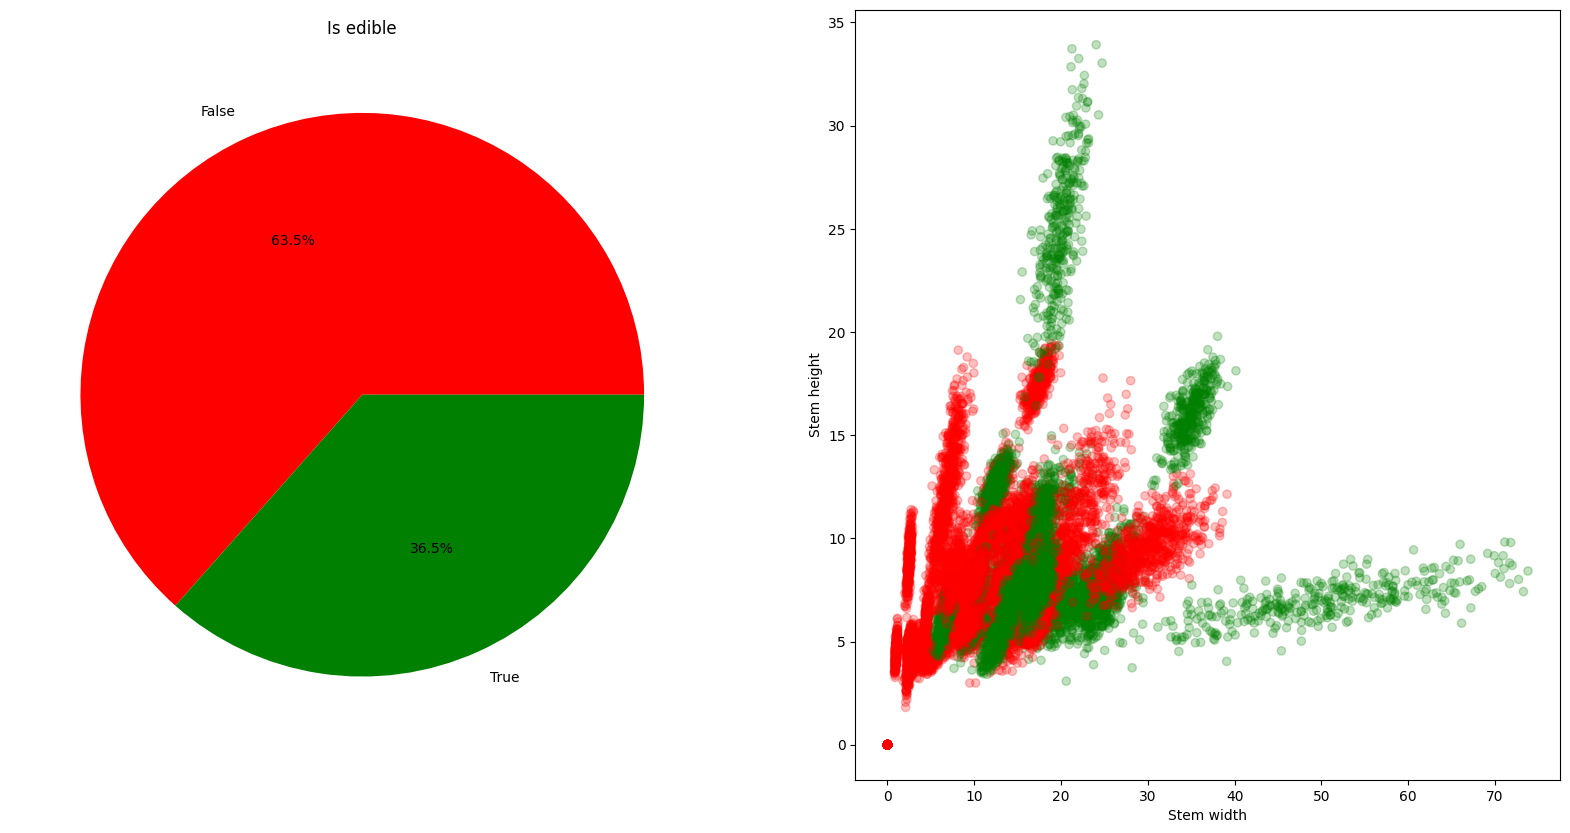

In [16]:
figsize = (20, 10)
is_edible_colors_map = {True: "green", False: "red"}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["is-edible"].value_counts().plot.pie(title="Is edible", colors=[is_edible_colors_map[False], is_edible_colors_map[True]], autopct="%1.1f%%", ylabel="", ax=axes[0])

axes[1].scatter(mushrooms["stem-width"], mushrooms["stem-height"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[1].set_xlabel("Stem width")
axes[1].set_ylabel("Stem height")

Si analizza la relazione della commestibilità con l'altezza e la larghezza del gambo. 

Si usa un grafico scatter plot per mostrare questa relazione, dove i funghi commestibili sono rappresentati in verde e quelli non commestibili in rosso. Ciò aiuta a identificare eventuali pattern che potrebbero essere utili per la classificazione.

Si osserva che nel dataset non esiste una chiara separazione tra funghi commestibili e non commestibili basata esclusivamente su queste tre caratteristiche; una classificazione basata solo su di esse è da ritenere non accurata.

Text(0, 0.5, 'Cap diameter')

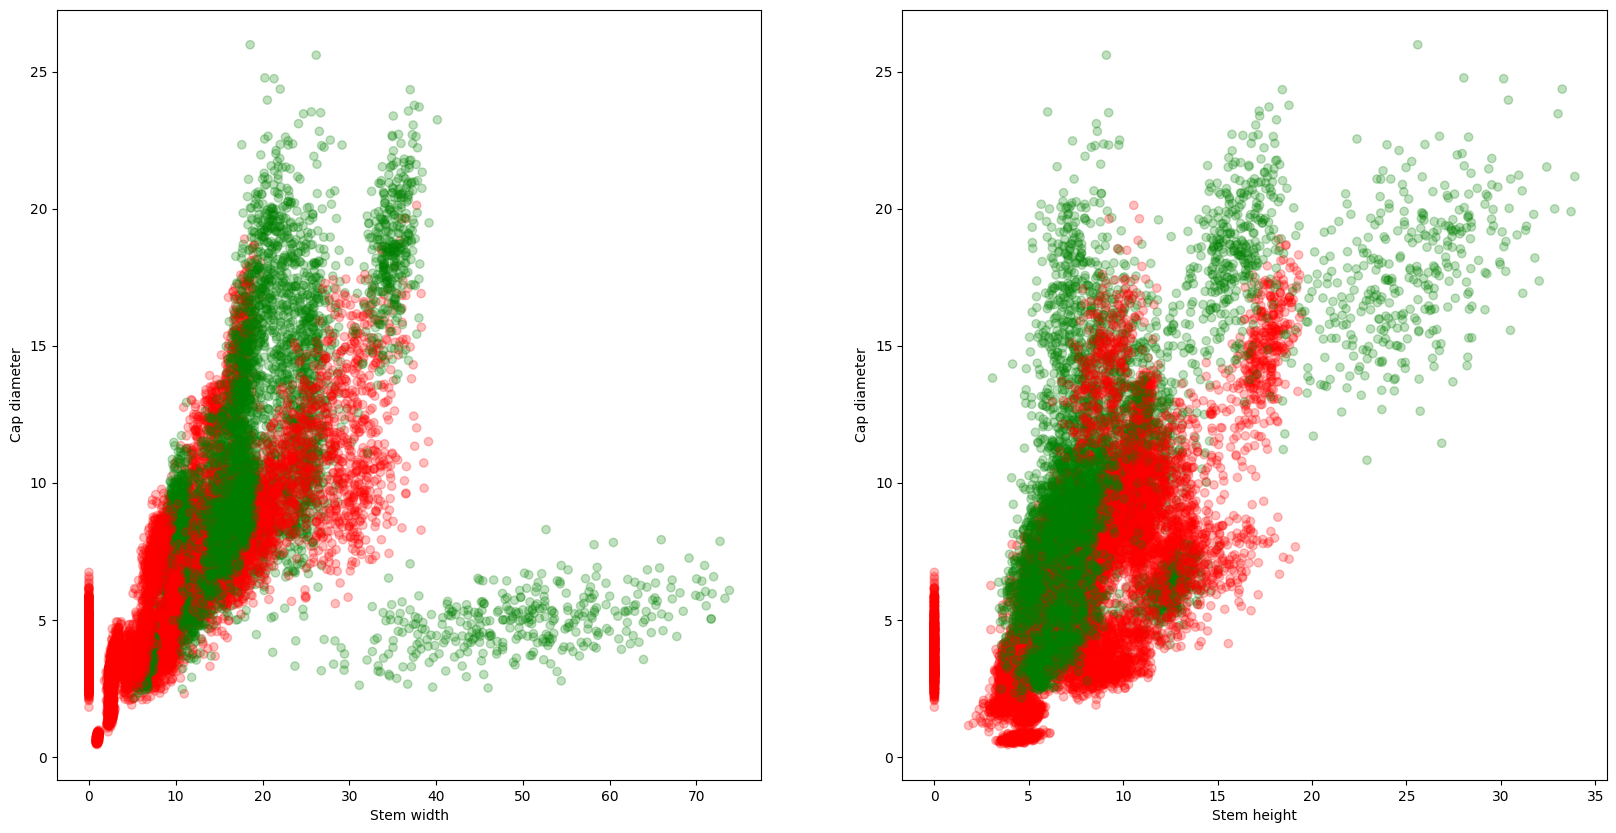

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].scatter(mushrooms["stem-width"], mushrooms["cap-diameter"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[0].set_xlabel("Stem width")
axes[0].set_ylabel("Cap diameter")

axes[1].scatter(mushrooms["stem-height"], mushrooms["cap-diameter"], c=mushrooms["is-edible"].map(is_edible_colors_map), alpha=0.25)
axes[1].set_xlabel("Stem height")
axes[1].set_ylabel("Cap diameter")

Si crea una funzione che, dato in input una specifica feature e le etichette per i suoi valori, mostri un grafico a barre con il numero di istanze commestibili e non commestibili per ciascun valore di quella feature.

L'obiettivo è poter osservare facilmente la distribuzione delle diverse categorie per ciascuna variabile. Ciò è utile per identificare quali categorie sono più comuni e se esiste una correlazione con la commestibilità dei funghi.

In [18]:
def plot_feature_against_is_edible_on_hist(feature, feature_values, ax):
    is_not_edible = mushrooms[mushrooms["is-edible"] == False][feature].dropna()
    is_edible = mushrooms[mushrooms["is-edible"] == True][feature].dropna()

    unique_values = pd.Series(mushrooms[feature].unique()).dropna()
    is_not_edible_value_counts = pd.DataFrame(is_not_edible.value_counts())
    is_edible_value_counts = pd.DataFrame(is_edible.value_counts())

    # riempimento con 0 per i valori mancanti della feature
    for unique_value in unique_values:
        if unique_value not in is_not_edible_value_counts.index:
            is_not_edible_value_counts.loc[unique_value] = 0
        if unique_value not in is_edible_value_counts.index:
            is_edible_value_counts.loc[unique_value] = 0

    # ordinamento degli indici
    is_not_edible_value_counts.sort_index(inplace=True)
    is_edible_value_counts.sort_index(inplace=True)

    hist_data = [
        {
            "label": 'Not edible',
            "data": is_not_edible_value_counts["count"],
            "color": is_edible_colors_map[False]
        },
        {
            "label": 'Edible',
            "data": is_edible_value_counts["count"],
            "color": is_edible_colors_map[True]
        }
    ]

    x = np.arange(len(feature_values))
    bars_width = len(feature_values) / figsize[0]

    for i in range(len(hist_data)):
        offset = bars_width * i
        ax.bar_label(ax.bar(x + offset, hist_data[i]["data"], bars_width, label=hist_data[i]["label"], color=hist_data[i]["color"]))

    ax.set_xticks(x + (bars_width / 2), feature_values)
    ax.legend()

La distribuzione dei tipi di inserzione delle lamelle al gambo è chiaramente variegata, come osservabile dal grafico a torta.

Il tipo di inserzione delle lamelle "free" tende ad avere una percentuale maggiore di funghi commestibili nel dataset. Tutti gli altri tipi mostrano una percentuale maggiore di funghi non commestibili come si poteva immaginare. Per i tipi "adnate" e "none" questa differenza è ancora più marcata.

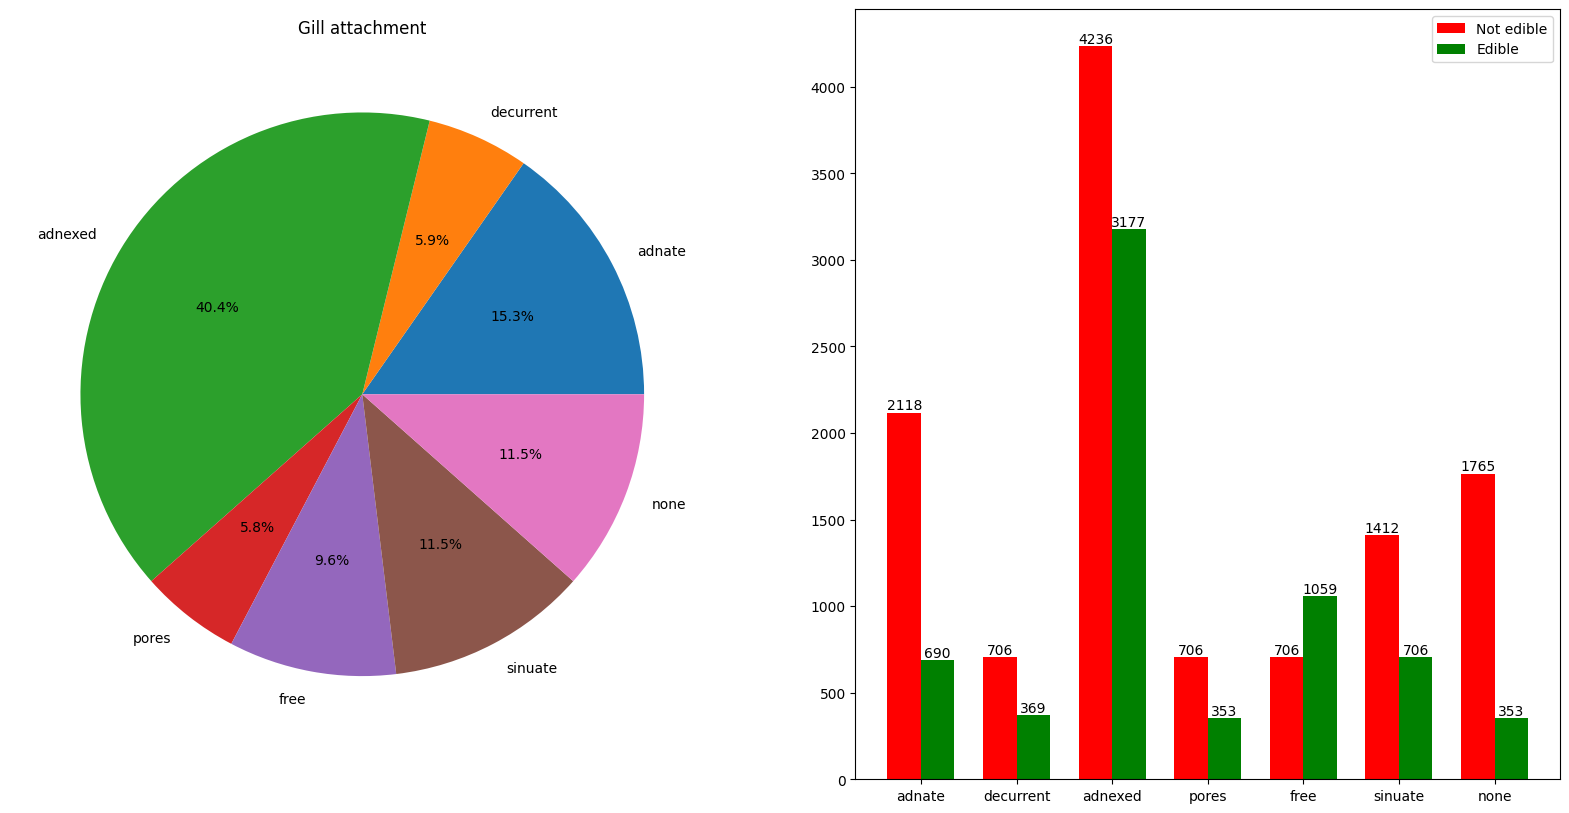

In [19]:
gill_attachment_values = ["adnate", "decurrent", "adnexed", "pores", "free", "sinuate", "none"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["gill-attachment"].value_counts().sort_index().plot.pie(title="Gill attachment", labels=gill_attachment_values, autopct="%1.1f%%", ylabel="", ax=axes[0])

plot_feature_against_is_edible_on_hist("gill-attachment", gill_attachment_values, axes[1])

Si osserva che nelle stagioni fredde (autunno e inverno) ci sono meno funghi commestibili rispetto ai non commestibili nel dataset. Al contrario, in primavera e in estate, la situazione, in proporzione, si inverte.

Inoltre, la metà dei funghi nel dataset ha come stagione d'appartenenza l'autunno.

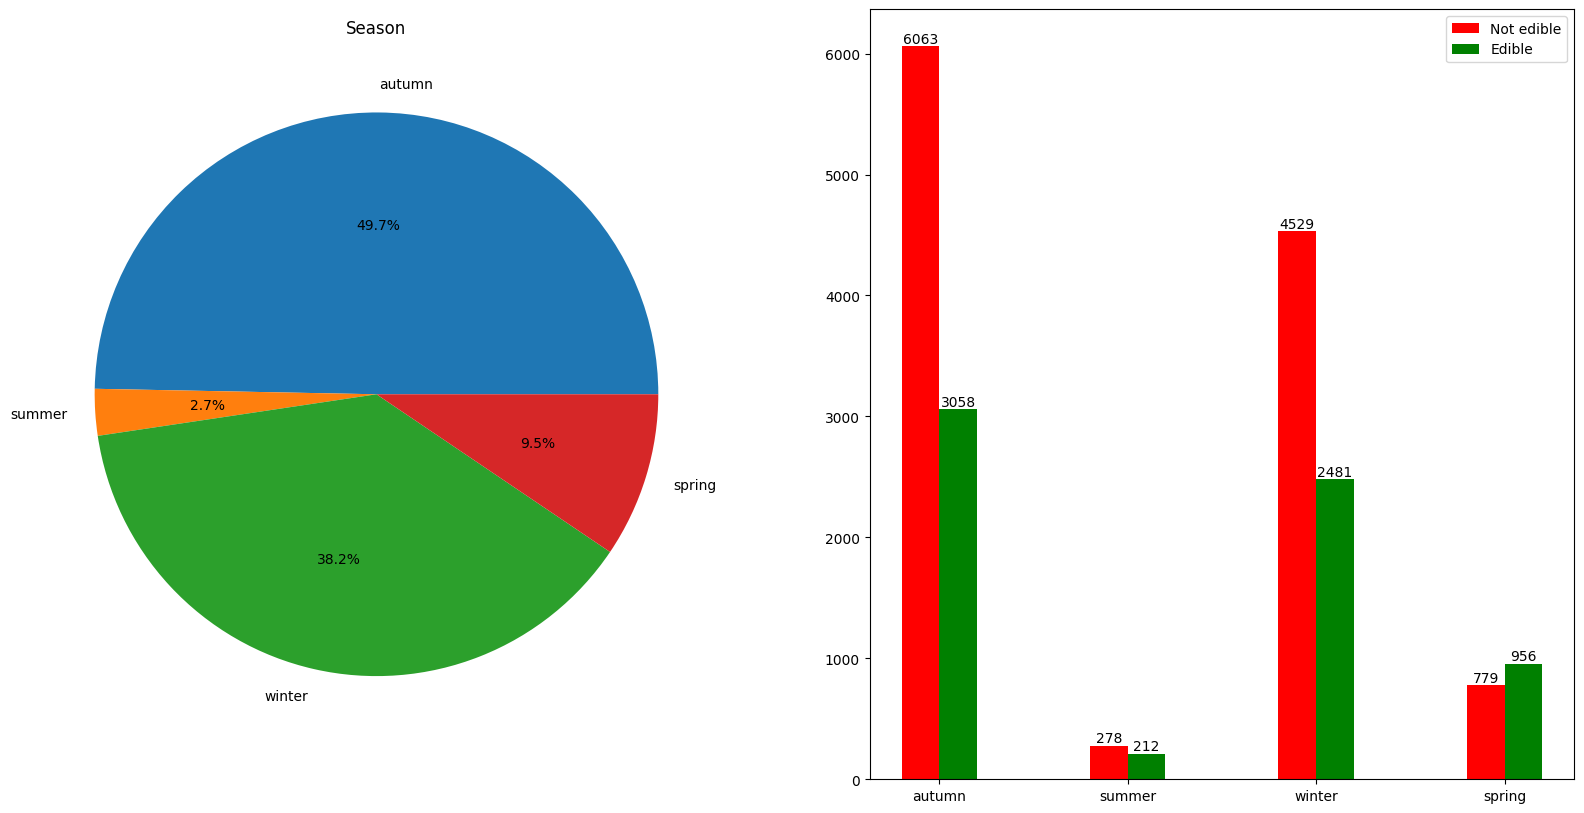

In [20]:
season_values = ["autumn", "summer", "winter", "spring"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

mushrooms["season"].value_counts().sort_index().plot.pie(title="Season", labels=season_values, autopct="%1.1f%%", ylabel="", ax=axes[0])

plot_feature_against_is_edible_on_hist("season", season_values, axes[1])

La maggior parte dei funghi ha il cappello di colore bianco. Inoltre, per tutti i colori la differenza tra il numero di funghi commestibili e no è netta.

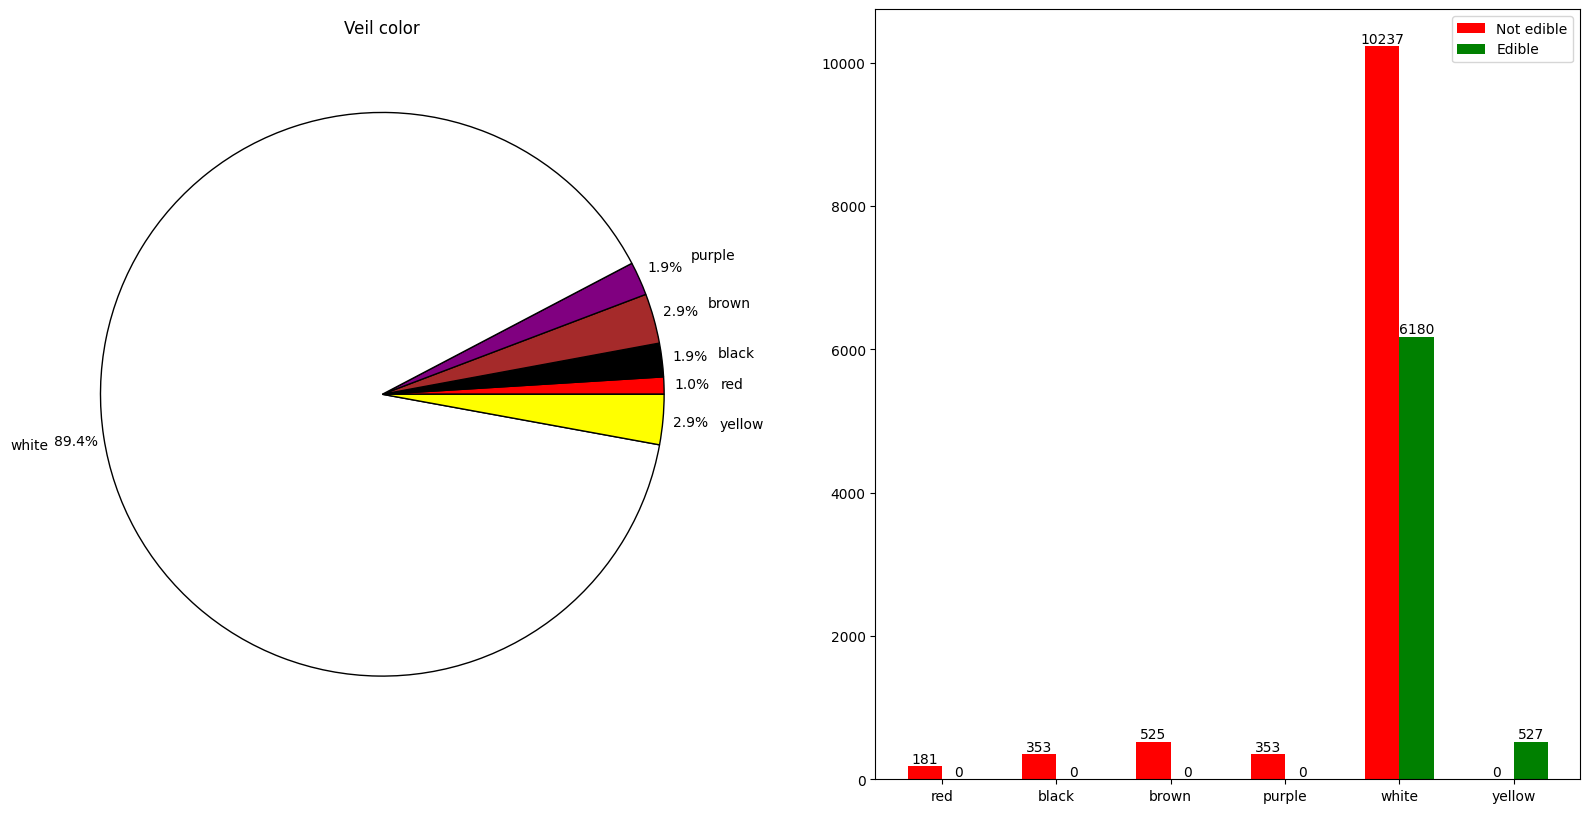

In [21]:
veil_color_values = ["red", "black", "brown", "purple", "white", "yellow" ]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].pie(mushrooms["veil-color"].value_counts().sort_index(), labels=veil_color_values, colors=veil_color_values, autopct="%1.1f%%", pctdistance=1.1, labeldistance=1.2, wedgeprops={"edgecolor": "black"}, textprops={"color": "black"})
axes[0].set_title("Veil color")

plot_feature_against_is_edible_on_hist("veil-color", veil_color_values, axes[1])

Si osserva che la maggior parte dei funghi ha come habitat i boschi (0.0) ed esistono solo due habitat outlier: le foglie (3.0) e i prati (4.0).

La forma del cappello, invece, non presenta outliers e il suo intervallo interquartile è simmetrico rispetto alla media. Questo indica che i dati sono distribuiti in modo equilibrato.

Text(0.5, 1.0, 'Cap Shape Boxplot')

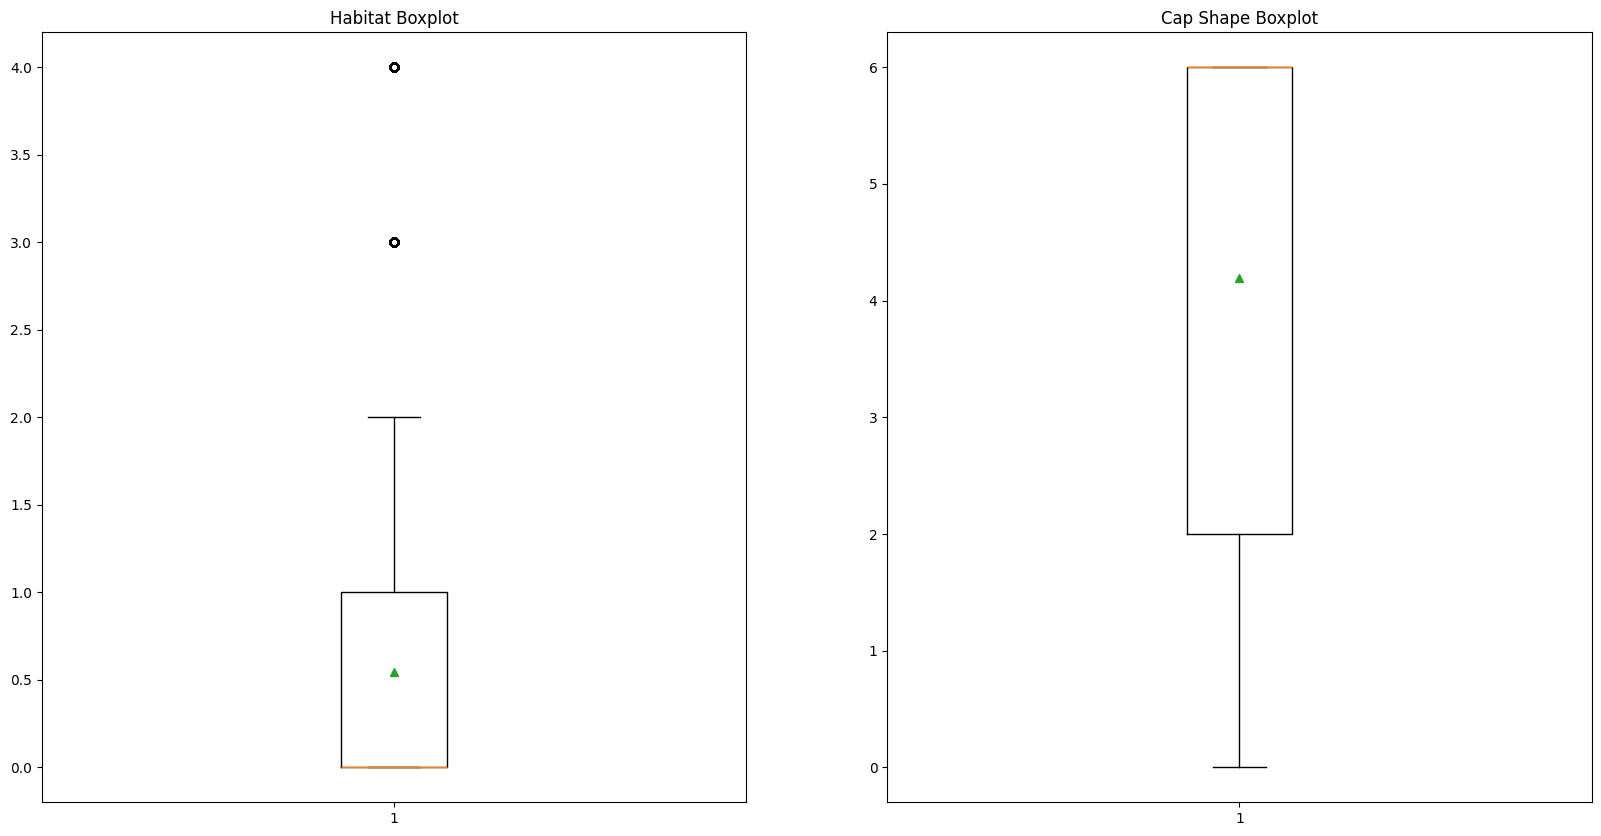

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

axes[0].boxplot(mushrooms["habitat"], showmeans=True)
axes[0].set_title("Habitat Boxplot")

axes[1].boxplot(mushrooms["cap-shape"], showmeans=True)
axes[1].set_title("Cap Shape Boxplot")

### Ulteriori miglioramenti
Si verifica inoltre che nessuna delle feature abbia più del 99% dei valori identici. In tal caso quelle feature sarebbero dovute essere rimosse perché praticamente costanti.

In [23]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(mushrooms)

[column for column in mushrooms.columns if column not in sel.get_feature_names_out()]

[]

Si esegue il One Hot Encoding delle variabili categoriche per garantire che i modelli non le interpretino come variabili continue solo perché hanno valori scalari.

In [24]:
if one_hot_encoding:
    encoder = OneHotEncoder(sparse_output=False)

    encoded_category_data = encoder.fit_transform(mushrooms[category_columns])
    encoded_categories = pd.DataFrame(encoder.fit_transform(mushrooms[category_columns]), index=mushrooms.index, columns=encoder.get_feature_names_out())

    mushrooms.drop(columns=category_columns, inplace=True)
    mushrooms = pd.concat([mushrooms, encoded_categories], axis=1)

    display(mushrooms.describe())

,cap-diameter,stem-height,stem-width,cap-shape_0.0,cap-shape_1.0,cap-shape_2.0,cap-shape_3.0,cap-shape_4.0,cap-shape_5.0,cap-shape_6.0,...,spore-print-color_6.0,habitat_0.0,habitat_1.0,habitat_2.0,habitat_3.0,habitat_4.0,season_0.0,season_1.0,season_2.0,season_3.0
count,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,...,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000,18356.000000
mean,7.491805,8.066530,13.301566,0.095010,0.009534,0.213118,0.066845,0.050774,0.029800,0.534920,...,0.066027,0.711756,0.175692,0.018632,0.044400,0.049521,0.496895,0.026694,0.381891,0.094520
std,4.258446,4.310421,9.738472,0.293236,0.097177,0.409522,0.249760,0.219541,0.170038,0.498793,...,0.248337,0.452957,0.380568,0.135223,0.205987,0.216958,0.500004,0.161193,0.485863,0.292558
min,0.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.040000,5.540000,6.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.970000,7.600000,12.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.500000,10.040000,17.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,25.980000,33.920000,73.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Si applica la normalizzazione l2 alle feature con valori scalari, si ottiene che l'influenza degli outlier sui risultati è ridotta. I dati sono quindi più uniformi e comparabili.

In [25]:
if normalize_data:
    float_columns = mushrooms.select_dtypes(include="float64").columns

    normalizer = Normalizer(norm="l2")
    mushrooms[float_columns] = normalizer.fit_transform(mushrooms[float_columns])

    display(mushrooms.describe())

Si effettua la standardizzazione dei dati, scalando le feature in modo che abbiano media 0 e deviazione standard 1. Questo fa si che tutte le feature contribuiscano equamente, indipendentemente dalla loro scala originale.

In [26]:
if standardize_data:
    float_columns = mushrooms.select_dtypes(include="float64").columns

    scaler = StandardScaler()
    mushrooms[float_columns] = scaler.fit_transform(mushrooms[float_columns])

    display(mushrooms.describe())

,cap-diameter,stem-height,stem-width,cap-shape_0.0,cap-shape_1.0,cap-shape_2.0,cap-shape_3.0,cap-shape_4.0,cap-shape_5.0,cap-shape_6.0,...,spore-print-color_6.0,habitat_0.0,habitat_1.0,habitat_2.0,habitat_3.0,habitat_4.0,season_0.0,season_1.0,season_2.0,season_3.0
count,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,18356.000000,1.835600e+04,...,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04,1.835600e+04
mean,2.105771e-16,7.432131e-17,6.193443e-18,-1.238689e-17,4.645082e-17,-7.432131e-17,1.486426e-16,-7.122459e-17,0.000000,-8.670820e-17,...,1.238689e-17,-1.238689e-17,1.796098e-16,8.051476e-17,6.193443e-17,8.670820e-17,-2.477377e-17,6.193443e-18,1.935451e-17,1.858033e-17
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027,1.000027e+00,...,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00
min,-1.656002e+00,-1.871453e+00,-1.365915e+00,-3.240129e-01,-9.810929e-02,-5.204220e-01,-2.676432e-01,-2.312778e-01,-0.175256,-1.072460e+00,...,-2.658859e-01,-1.571397e+00,-4.616694e-01,-1.377869e-01,-2.155518e-01,-2.282557e-01,-9.938087e-01,-1.656092e-01,-7.860273e-01,-3.230883e-01
25%,-8.106007e-01,-5.861605e-01,-6.820112e-01,-3.240129e-01,-9.810929e-02,-5.204220e-01,-2.676432e-01,-2.312778e-01,-0.175256,-1.072460e+00,...,-2.658859e-01,-1.571397e+00,-4.616694e-01,-1.377869e-01,-2.155518e-01,-2.282557e-01,-9.938087e-01,-1.656092e-01,-7.860273e-01,-3.230883e-01
50%,-1.225376e-01,-1.082359e-01,-9.874162e-02,-3.240129e-01,-9.810929e-02,-5.204220e-01,-2.676432e-01,-2.312778e-01,-0.175256,9.324360e-01,...,-2.658859e-01,6.363766e-01,-4.616694e-01,-1.377869e-01,-2.155518e-01,-2.282557e-01,-9.938087e-01,-1.656092e-01,-7.860273e-01,-3.230883e-01
75%,4.715920e-01,4.578495e-01,4.578290e-01,-3.240129e-01,-9.810929e-02,-5.204220e-01,-2.676432e-01,-2.312778e-01,-0.175256,9.324360e-01,...,-2.658859e-01,6.363766e-01,-4.616694e-01,-1.377869e-01,-2.155518e-01,-2.282557e-01,1.006230e+00,-1.656092e-01,1.272220e+00,-3.230883e-01
max,4.341653e+00,5.998062e+00,6.212482e+00,3.086297e+00,1.019271e+01,1.921517e+00,3.736317e+00,4.323804e+00,5.705926,9.324360e-01,...,3.761012e+00,6.363766e-01,2.166052e+00,7.257583e+00,4.639256e+00,4.381052e+00,1.006230e+00,6.038313e+00,1.272220e+00,3.095130e+00


## Selezione delle feature

In [27]:
y = mushrooms["is-edible"]
X = mushrooms.drop(columns="is-edible")

Si usa la funzione SelectKBest per selezionare le k migliori feature. Le feature vengono valutate e classificate in base al loro impatto sulla predizione del modello. Riducendo il numero di feature, il modello diventa più veloce e portabile nel fare predizioni senza compromettere significativamente il risultato.

In [28]:
if k_best_features_to_select > 0:
    selector = SelectKBest(k=k_best_features_to_select)
    best_features = selector.fit_transform(X, y)

    X = pd.DataFrame(best_features, columns=selector.get_feature_names_out())
    print(X.columns)

## Sviluppo di un modello
### Suddivisione dei dati
Si divide il dataset in due parti: 2/3 dei dati per l'addestramento dei modelli (`_train`) e il restante 1/3 per il testing (`_test`). La porzione destinata al testing è ulteriormente suddivisa in due parti: 2/3 per la validazione dei modelli (`_val`) e il restante 1/3 per la verifica finale dell'overfitting del modello (`_overfit`).

I dati iniziali sono stati quindi suddivisi così:
- 6/9 per l'addestramento
- 2/9 per la validazione
- 1/9 per la verifica finale dell'overfitting

Questo approccio garantisce che i dati utilizzati per verificare l'overfitting non siano coinvolti nelle fasi di addestramento e miglioramento del modello.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

X_val, X_overfit, y_val, y_overfit = train_test_split(
    X_test, y_test,
    test_size=1/3,
    random_state=42
)

Si prepara la Cross Validation con 3 fold, quindi i modelli verranno valutati 3 volte utilizzando dati diversi ogni volta. Ogni fold mantiene la stessa proporzione di valori della variabile "target", garantendo una valutazione equilibrata. Si ottiene che la valutazione dei modelli è più affidabile perché eseguita 3 volte e su dati diversi.

In [30]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

### Scelta del modello

Si crea una funzione che valuti un modello e ne riporti l'Accuracy, la Precision, il Recall e l'F1-Score. Viene anche mostrata la matrice di confusione, utile per visualizzare facilmente il numero di falsi negativi e falsi positivi prodotti dal modello.

In [31]:
def print_eval(X, y, model):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy:.5}")

    print("Classification report")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

Si crea una funzione che presi i dati di allenamento, un modello e un grid di parametri esegua Grid Search CV e mostri i 5 migliori modelli trovati.

In [32]:
def grid_search_fit_and_print(X_train, y_train, model, grid):
    grid_search = GridSearchCV(model, grid, cv=skf, scoring="accuracy")
    grid_search.fit(X_train, y_train)

    display(pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score").head(5))

    return grid_search

#### Logistic Regression
Si è scelto come solver `saga` in quanto permette di applicare penalizzazioni sia l2 che l1.

Tramite Grid Search si prova la combinazione di:
- Usare la penalità l1 o l2
- Aggiungere o meno l'intercetta alla funzione di decisione

/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__fit_intercept,param_lr__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,1.057938,0.082868,0.006555,0.000354,True,l1,"{'lr__fit_intercept': True, 'lr__penalty': 'l1'}",1.00000,0.999755,0.999265,0.999673,0.000306,1
2,0.775075,0.051045,0.005598,0.000333,True,l2,"{'lr__fit_intercept': True, 'lr__penalty': 'l2'}",1.00000,0.999755,0.999265,0.999673,0.000306,1
1,1.014184,0.022876,0.006908,0.000899,False,l1,"{'lr__fit_intercept': False, 'lr__penalty': 'l1'}",0.99951,0.999019,0.999510,0.999346,0.000231,3
0,0.770803,0.018132,0.008091,0.000794,False,l2,"{'lr__fit_intercept': False, 'lr__penalty': 'l2'}",0.99951,0.998774,0.999265,0.999183,0.000306,4


Accuracy: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2635
        True       1.00      1.00      1.00      1444

    accuracy                           1.00      4079
   macro avg       1.00      1.00      1.00      4079
weighted avg       1.00      1.00      1.00      4079



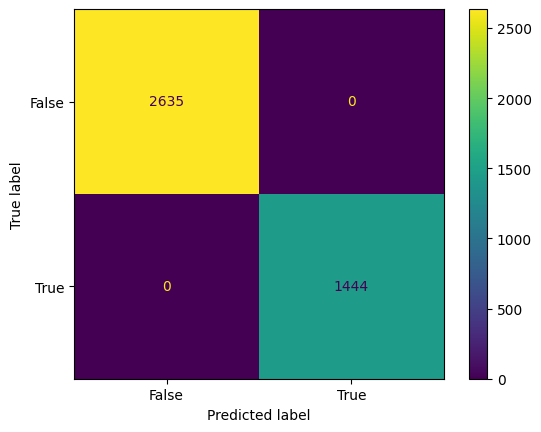

In [33]:
logreg_model = Pipeline([("lr", LogisticRegression(solver="saga", random_state=42))])
logreg_grid = {
    "lr__penalty": ["l2", "l1"],
    "lr__fit_intercept": [False, True]
}

logreg_grid_search = grid_search_fit_and_print(X_train, y_train, logreg_model, logreg_grid)
print_eval(X_val, y_val, logreg_grid_search)

#### Decision Tree
Tramite Grid Search si prova la combinazione di:
- Impostare la profondità massima dell'albero a 3, 4 o 5
- Impostare il numero minimo di istanze necessarie per eseguire uno split di un nodo a 2, 3 o 4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtc__max_depth,param_dtc__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,0.036795,0.000984,0.007041,0.000384,5,2,"{'dtc__max_depth': 5, 'dtc__min_samples_split'...",0.875950,0.929885,0.932336,0.912724,0.026022,1
7,0.036122,0.000402,0.007370,0.000304,5,3,"{'dtc__max_depth': 5, 'dtc__min_samples_split'...",0.875950,0.929885,0.932336,0.912724,0.026022,1
8,0.036804,0.000864,0.007900,0.000552,5,4,"{'dtc__max_depth': 5, 'dtc__min_samples_split'...",0.875950,0.929885,0.932336,0.912724,0.026022,1
3,0.033737,0.000633,0.007448,0.000143,4,2,"{'dtc__max_depth': 4, 'dtc__min_samples_split'...",0.773964,0.901937,0.900956,0.858952,0.060097,4
4,0.034657,0.001629,0.007647,0.000471,4,3,"{'dtc__max_depth': 4, 'dtc__min_samples_split'...",0.773964,0.901937,0.900956,0.858952,0.060097,4


Accuracy: 0.92964
Classification report
              precision    recall  f1-score   support

       False       1.00      0.89      0.94      2635
        True       0.84      0.99      0.91      1444

    accuracy                           0.93      4079
   macro avg       0.92      0.94      0.93      4079
weighted avg       0.94      0.93      0.93      4079



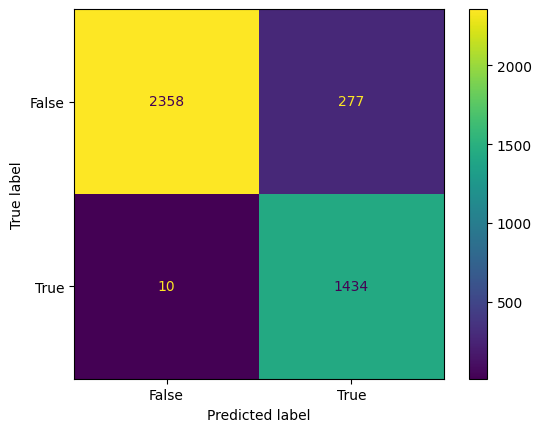

In [34]:
tree_model = Pipeline([("dtc", DecisionTreeClassifier(random_state=42))])
tree_grid = {
    'dtc__max_depth': range(3, 6),
    'dtc__min_samples_split': range(2, 5),
}

tree_grid_search = grid_search_fit_and_print(X_train, y_train, tree_model, tree_grid)
print_eval(X_val, y_val, tree_grid_search)

#### Random forest
Tramite Grid Search si prova la combinazione di:
- Impostare il numero minimo di istanze per considerare valida una foglia a 1, 2 o 3
- Usare 80, 90, 100 o 110 estimatori (alberi decisionali indipendenti usati per trovare la predizione migliore)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.491665,0.011517,0.030132,0.001673,1,80,"{'rf__min_samples_leaf': 1, 'rf__n_estimators'...",1.0,1.0,1.0,1.0,0.0,1
1,0.519325,0.040036,0.031249,0.000894,1,90,"{'rf__min_samples_leaf': 1, 'rf__n_estimators'...",1.0,1.0,1.0,1.0,0.0,1
2,0.594456,0.011453,0.035205,0.001205,1,100,"{'rf__min_samples_leaf': 1, 'rf__n_estimators'...",1.0,1.0,1.0,1.0,0.0,1
3,0.626734,0.038264,0.036755,0.000897,1,110,"{'rf__min_samples_leaf': 1, 'rf__n_estimators'...",1.0,1.0,1.0,1.0,0.0,1
4,0.449933,0.024521,0.029791,0.000555,2,80,"{'rf__min_samples_leaf': 2, 'rf__n_estimators'...",1.0,1.0,1.0,1.0,0.0,1


Accuracy: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2635
        True       1.00      1.00      1.00      1444

    accuracy                           1.00      4079
   macro avg       1.00      1.00      1.00      4079
weighted avg       1.00      1.00      1.00      4079



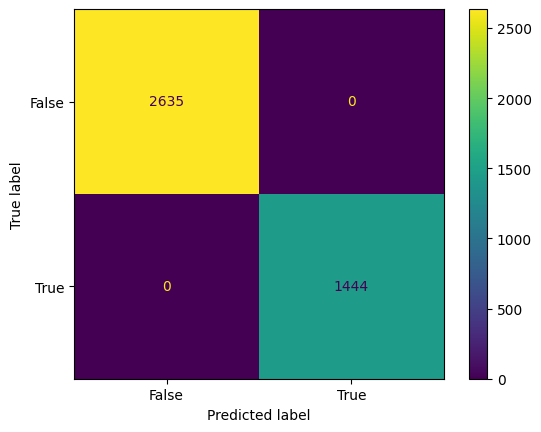

In [35]:
random_forest_model = Pipeline([("rf", RandomForestClassifier(random_state=42))])
random_forest_grid = {
    'rf__min_samples_leaf': range(1, 4),
    'rf__n_estimators': range(80, 120, 10),
}

random_forest_grid_search = grid_search_fit_and_print(X_train, y_train, random_forest_model, random_forest_grid)
print_eval(X_val, y_val, random_forest_grid_search)

#### KNN Classifier
Il K-Nearest Neighbors (KNN) Classifier è un algoritmo di classificazione che classifica le istanze in base alle classi delle K istanze più vicine. La "vicinanza" viene solitamente misurata usando la distanza Euclidea.

Tramite Grid Search si prova la combinazione di:
- Tenere in considerazione 3, 4, 5 o 6 istanze vicine ogni volta
- Dare a tutti i vicini lo stesso peso oppure modificarlo in base alla distanza dall'istanza da classificare

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023486,0.003664,0.252566,0.012574,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",1.0,1.0,1.0,1.0,0.0,1
1,0.023594,0.001708,0.079725,0.009600,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",1.0,1.0,1.0,1.0,0.0,1
2,0.021029,0.002639,0.251399,0.007252,4,uniform,"{'knn__n_neighbors': 4, 'knn__weights': 'unifo...",1.0,1.0,1.0,1.0,0.0,1
3,0.019299,0.001686,0.076495,0.001137,4,distance,"{'knn__n_neighbors': 4, 'knn__weights': 'dista...",1.0,1.0,1.0,1.0,0.0,1
4,0.019606,0.001158,0.255844,0.002969,5,uniform,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",1.0,1.0,1.0,1.0,0.0,1


Accuracy: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2635
        True       1.00      1.00      1.00      1444

    accuracy                           1.00      4079
   macro avg       1.00      1.00      1.00      4079
weighted avg       1.00      1.00      1.00      4079



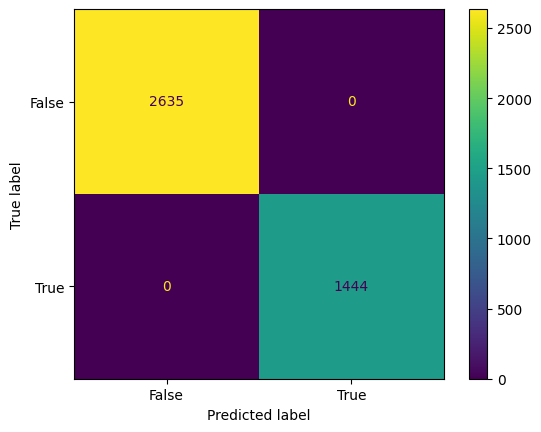

In [36]:
knn_model = Pipeline([("knn", KNeighborsClassifier())])
knn_grid = {
    'knn__n_neighbors': range(3, 7),
    'knn__weights': ['uniform', 'distance']
}

knn_grid_search = grid_search_fit_and_print(X_train, y_train, knn_model, knn_grid)
print_eval(X_val, y_val, knn_grid_search)

### Valutazione finale dei modelli
Si osserva che un modello completamente casuale ottiene uno score di 0.64, molto inferiore agli score ottenuti dai modelli appena sviluppati.

Accuracy: 0.64599
Classification report
              precision    recall  f1-score   support

       False       0.65      1.00      0.78      2635
        True       0.00      0.00      0.00      1444

    accuracy                           0.65      4079
   macro avg       0.32      0.50      0.39      4079
weighted avg       0.42      0.65      0.51      4079



/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

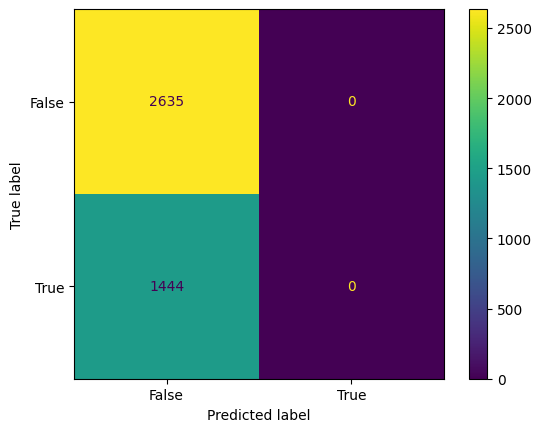

In [37]:
dummy_model = DummyClassifier(random_state=42)
dummy_model.fit(X_train, y_train)

print_eval(X_val, y_val, dummy_model)

Siccome Precision e Recall sono spesso in trade-off reciproco, la Precision-Recall Curve è utile per visualizzare chiaramente come varia la Precision al variare della Recall e quali modelli performino meglio.

È importante notare che in questo caso i migliori modelli raggiungono Precision e Recall pari a 1.0, indicando una performance "perfetta". Questo non è vero per il modello basato su Decision Tree.

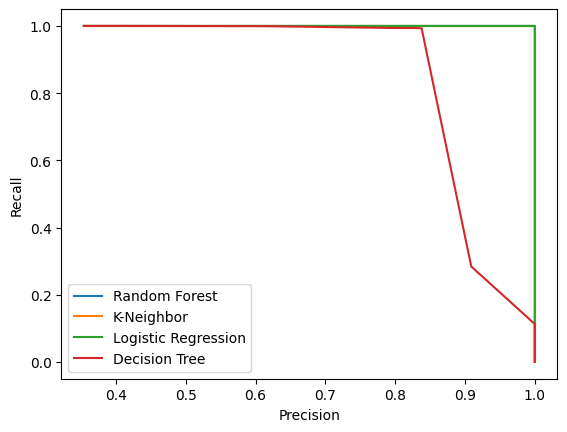

In [38]:
precision_rf, recall_rf, _ = precision_recall_curve(y_val, random_forest_grid_search.predict_proba(X_val)[:, 1])
precision_knn, recall_knn, _ = precision_recall_curve(y_val, knn_grid_search.predict_proba(X_val)[:, 1])
precision_logreg, recall_logreg, _ = precision_recall_curve(y_val, logreg_grid_search.predict_proba(X_val)[:, 1])
precision_tree, recall_tree, _ = precision_recall_curve(y_val, tree_grid_search.predict_proba(X_val)[:, 1])

plt.plot(precision_rf, recall_rf, label="Random Forest")
plt.plot(precision_knn, recall_knn, label="K-Neighbor")
plt.plot(precision_logreg, recall_logreg, label="Logistic Regression")
plt.plot(precision_tree, recall_tree, label="Decision Tree")

plt.xlabel("Precision")
plt.ylabel("Recall")

plt.legend(loc="lower left")

Infine, si verifica l'overfitting dei modelli sviluppati. Per farlo si valuta il modello su dati mai usati durante l'addestramento o la validazione, perciò completamente nuovi.

Accuracy: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1298
        True       1.00      1.00      1.00       742

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



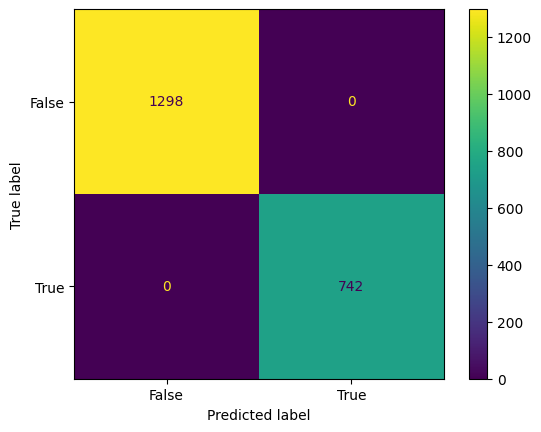

In [39]:
print_eval(X_overfit, y_overfit, logreg_grid_search)

Accuracy: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1298
        True       1.00      1.00      1.00       742

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



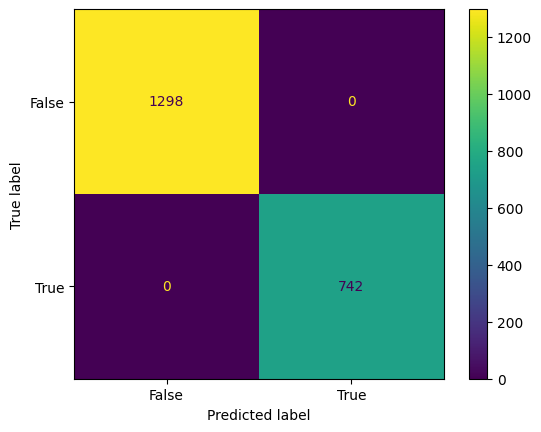

In [40]:
print_eval(X_overfit, y_overfit, random_forest_grid_search)

Accuracy: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1298
        True       1.00      1.00      1.00       742

    accuracy                           1.00      2040
   macro avg       1.00      1.00      1.00      2040
weighted avg       1.00      1.00      1.00      2040



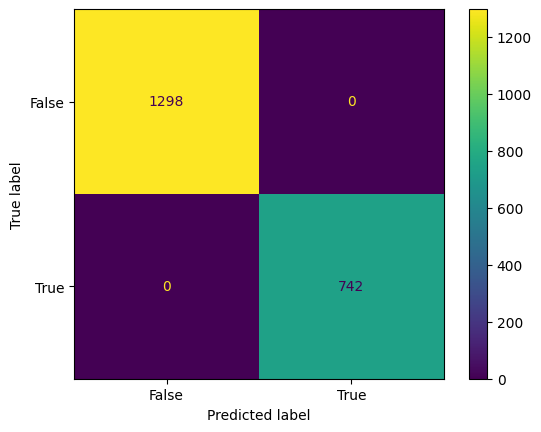

In [41]:
print_eval(X_overfit, y_overfit, knn_grid_search)

## Conclusioni finali
Utilizzando la configurazione standard (`standard_config`), si sono ottenute performance eccellenti per tutti i modelli, ad eccezione di quello basato su Decision Tree. I tre migliori modelli hanno raggiunto un'accuratezza di 1.0 nella verifica dell'overfitting, dimostrando il successo dello studio condotto.

Questo risultato è confermato anche testando le altre configurazioni disponibili. Disabilitando sia la standardizzazione che la normalizzazione (`standard_config_no_std_no_norm`), i modelli basati su KNN e Logistic Regression hanno ottenuto un'accuratezza rispettivamente di 0.99 e 0.97 nella verifica dell'overfitting.

Quando si disabilita la rimozione delle righe con valori nulli in colonne che hanno almeno l'80% di valori nulli (`standard_config_no_rows_deletion`), i modelli basati su KNN e Logistic Regression ottengono un'accuratezza di 0.99 e 0.84 nella verifica dell'overfitting. Questo suggerisce che la rimozione di quelle istanze è stata una scelta corretta, in quanto peggiorano la qualità del dataset e rallentano l'addestramento.

Si valuta ora l'impatto della selezione delle migliori feature del dataset, si nota che selezionando le 5 migliori feature e mantenendo attivo il one hot encoding (`5_features_with_one_hot_encoding`), le performance ottenute sono pessime. Tuttavia, disattivando il one hot encoding (`5_features_no_one_hot_encoding`), i modelli basati su KNN e Random Forest raggiungono rispettivamente un'accuratezza di 0.96 e 0.95 nella verifica dell'overfitting. Questo risultato è coerente, poiché disattivare il one hot encoding preserva il "valore" delle feature, evitando di distribuirlo su più variabili.

Si riportano i punteggi di accuratezza ottenuti durante la verifica dell'overfitting da ciascuna configurazione:
- `standard_config`: 1.00 on KNN, 1.00 on Random Forest, 1.00 on Logistic Regression
- `standard_config_no_std_no_norm`: 0.99 on KNN, 1.00 on Random Forest, 0.97 on Logistic Regression
- `standard_config_no_rows_deletion`: 0.99 on KNN, 1.00 on Random Forest, 0.84 on Logistic Regression
- `5_features_with_one_hot_encoding`: 0.79 on KNN, 0.79 on Random Forest, 0.73 on Logistic Regression
- `5_features_no_one_hot_encoding`: 0.96 on KNN, 0.95 on Random Forest, 0.74 on Logistic Regression

Alla luce dei risultati ottenuti nelle diverse configurazioni, il modello basato su Random Forest risulta il più performante; viene quindi salvato su un file.

In [42]:
joblib.dump(random_forest_grid_search.best_estimator_, "random_forest_model.pkl")

['random_forest_model.pkl']